In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import poisson

from Class_utils.parameters import *
from Class_utils.FitnessFunctions import  FitnessFunctions as fitfunction
from Generator.MatchingScore import MatchingScore
%reload_ext autoreload
%autoreload 2

# Distributions

In [2]:
df_language_level = pd.read_csv(file_paths["languages_level_path"],index_col=0) # dataframe with language levels

poisson_dist = [poisson(lam=2) for _ in range(60000)]
poisson_x = [i for i in range(max(poisson_dist))]

df_education_level = pd.read_csv(file_paths["education_path"]) # dataframe with language levels
education_level_dist =  df_education_level["Distribution"].tolist()
name_edu_levels = df_education_level["Education"]

dt_language = pd.read_csv(file_paths["languages_path"],index_col=0)
languages,prob = dt_language.index.to_numpy(), dt_language.Prob.to_numpy()
sorted_order = np.argsort(prob,kind="stable")
languages,prob = languages[sorted_order], prob[sorted_order]

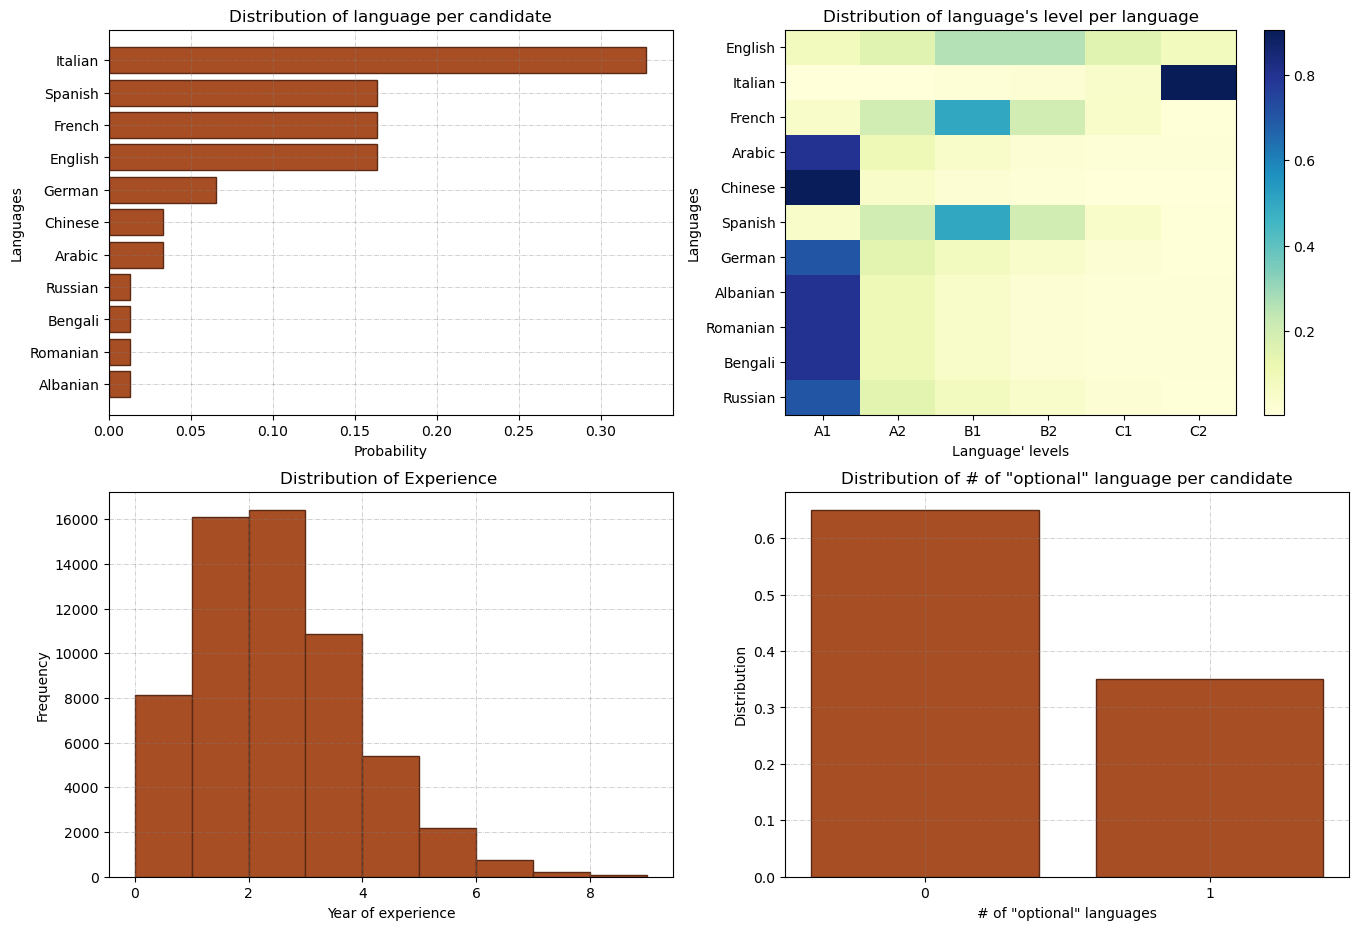

In [3]:
default_par = dict(
    color="#a74e25",
    edgecolor="#5b2a14"
)

f, axs = plt.subplots(ncols=2,nrows=2,figsize=(16,11))

axs[0,0].barh(range(len(languages)), prob/prob.sum(), **default_par)
axs[0,0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0,0].set_yticks(range(len(languages)), languages)
axs[0,0].set_title('Distribution of language per candidate')
axs[0,0].set_xlabel('Probability')
axs[0,0].set_ylabel('Languages')

img = axs[0,1].imshow(df_language_level.values, cmap='YlGnBu', interpolation='nearest', aspect='auto')
axs[0,1].set_title('Distribution of language\'s level per language')
axs[0,1].set_xticks(range(df_language_level.   shape[1]), list(df_language_level.columns))
axs[0,1].set_yticks(range(df_language_level.shape[0]), list(df_language_level.index))
axs[0,1].set_xlabel('Language\' levels')
axs[0,1].set_ylabel('Languages')

axs[1,0].hist(poisson_dist, poisson_x, **default_par)
axs[1,0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1,0].set_title('Distribution of Experience ')
axs[1,0].set_xlabel('Year of experience')
axs[1,0].set_ylabel('Frequency')

axs[1,1].bar(range(len(file_paths["opt_lang_distribution"])), file_paths["opt_lang_distribution"], **default_par)
axs[1,1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1,1].set_xticks(range(len(file_paths["opt_lang_distribution"])), range(len(file_paths["opt_lang_distribution"])))
axs[1,1].set_title('Distribution of # of "optional" language per candidate')
axs[1,1].set_xlabel('# of "optional" languages')
axs[1,1].set_ylabel('Distribution')

plt.colorbar(img, ax=axs[0,1])
plt.show()


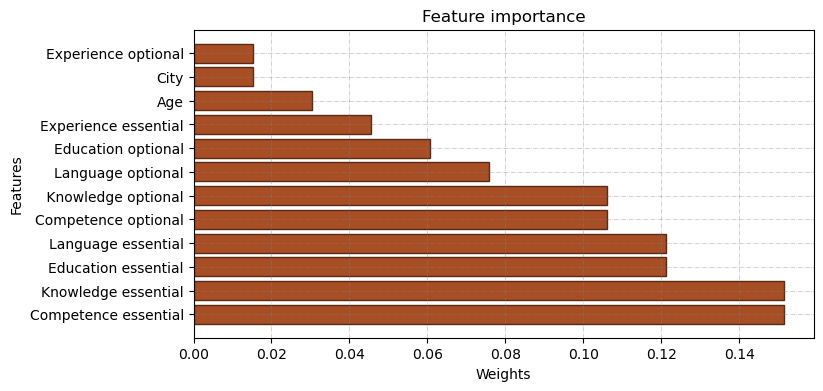

In [4]:
n_weights = MatchingScore.normalize_weights(matching_par["weight"])

sort_ = np.argsort(-n_weights)

features = np.array(["Education essential","Education optional","City","Age","Experience essential","Experience optional","Language essential","Language optional", "Competence essential","Competence optional","Knowledge essential"," Knowledge optional"])

_, axs = plt.subplots(figsize=(8,4))
axs.barh(range(len(n_weights)), n_weights[sort_], **default_par)
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_yticks(range(len(n_weights)), features[sort_])
axs.set_title("Feature importance")
axs.set_xlabel('Weights')
axs.set_ylabel('Features')
plt.show()

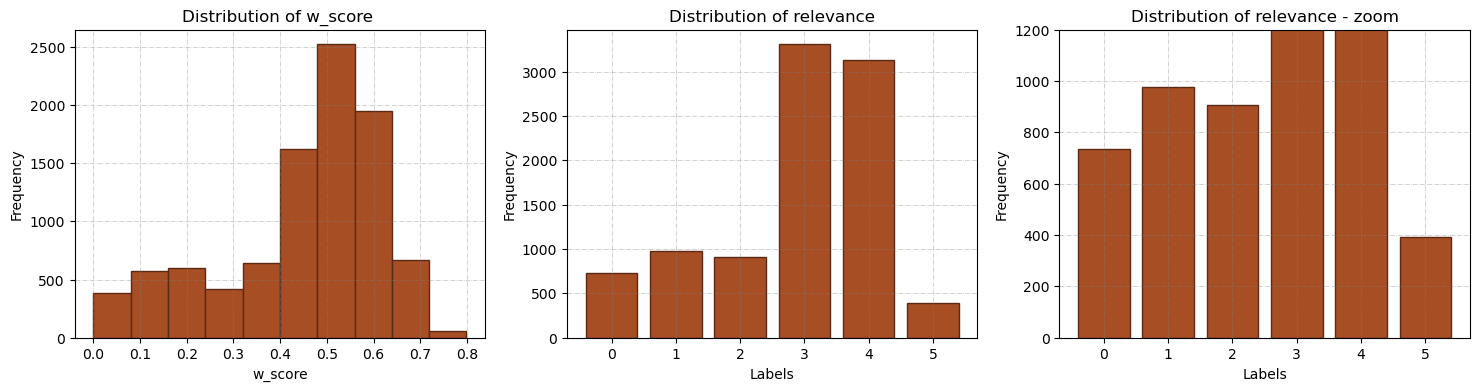

In [5]:
score_dt = pd.read_csv("../outputs/scores/0_dataset.csv")
relevance = score_dt["relevance"].tolist()
w_score = score_dt["w_score"].tolist()

distri_labels = [relevance.count(i) for i in range(max(relevance)+1)]
name_label = [*range(max(relevance)+1)]

_, axs = plt.subplots(ncols=3,figsize=(18,4))

axs[0].hist(w_score, **default_par)
axs[0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0].set_title('Distribution of w_score ')
axs[0].set_xlabel('w_score')
axs[0].set_ylabel('Frequency')

axs[1].bar(name_label,distri_labels, **default_par)
axs[1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1].set_title('Distribution of relevance')
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')

axs[2].bar(name_label,distri_labels, **default_par)
axs[2].set_ylim(0, 1200)
axs[2].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[2].set_title('Distribution of relevance - zoom')
axs[2].set_xlabel('Labels')
axs[2].set_ylabel('Frequency')


plt.show()

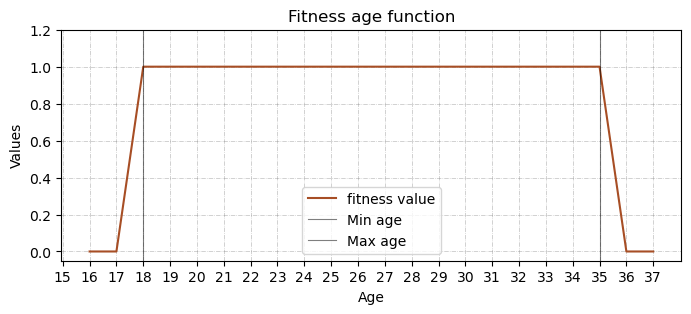

In [6]:
min_age, max_age = 18, 35
ages = [*range(16,37+1)]
age_score = [fitfunction.fitness_age_function(i,min_age,max_age) for i in ages]

_, axs = plt.subplots(figsize=(8,3))

axs.plot(ages,age_score, color=default_par["color"],label="fitness value")
axs.axvline(min_age, alpha=0.5,linewidth=0.8, color="black", label="Min age")
axs.axvline(max_age, alpha=0.5,linewidth=0.8, color="black", label="Max age")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_ylim(-0.05,1.2)
axs.set_xticks(np.arange(15, 37 + 1, 1))
axs.set_title("Fitness age function")
axs.set_xlabel('Age')
axs.set_ylabel('Values')
axs.legend()
plt.show()

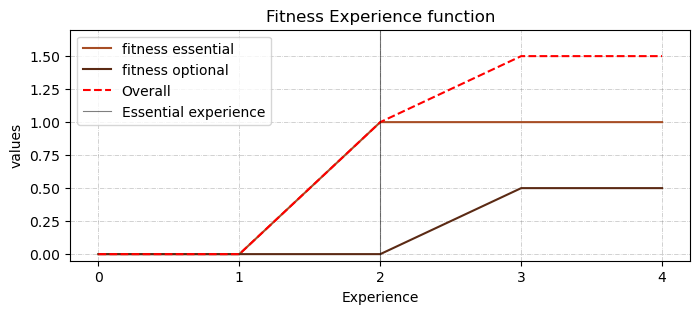

In [8]:
exp_essential,exp_optional = 2, True
experience = [*range(0,5)]

basic_score, bonus_score = [], []
for i in experience:
    a,b = fitfunction.fitness_experience_function(exp_essential, exp_optional, i)
    basic_score.append(a)
    bonus_score.append(b)

overall = [a + b for a,b in zip(basic_score,bonus_score)]
_, axs = plt.subplots(figsize=(8,3))

axs.plot(experience, basic_score, color=default_par["color"], label="fitness essential")
axs.plot(experience, bonus_score, color=default_par["edgecolor"], label="fitness optional")
axs.plot(experience, overall, color="red", linestyle="--", label="Overall")
axs.axvline(exp_essential, alpha=0.5,linewidth=0.8, color="black", label="Essential experience")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_ylim(-0.05,1.7)
axs.set_xticks(np.arange(0,5,1))
axs.set_title("Fitness Experience function")
axs.set_xlabel('Experience')
axs.set_ylabel('values')
axs.legend()
plt.show()